In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

import sys, os
sys.path.append('../')
from galaxybrain import ramsey 

# Piles o' Sand

TODO: 
- adding grains at time intervals and random points (random initial conditions like in BTW), like external or internal inputs, and allow sand to overflow (get continuous oscillations that way)
    - versus allowing resonance on walls (what does this say about inputs/outputs?)
    - Or more simply what about just having sources and sinks
- Also how about varying topple thereshold? Graphs allow for higher dimensionality than grid
- Compute spectra of cluster sizes, "lifetimes"
- Compute spectra from ramsey pipeline

$Vectorized code instead of looping to make faster (how to quantify time complexity with current loops?  It's something like O(n^2)
    - https://link.springer.com/chapter/10.1007/978-94-015-9153-9_6

$need smaller ranged colormap otherwise big avalanches are big outliers

[JS version here](http://www.natureincode.com/code/various/sandpile.html)

$O(n)

In [10]:
# from https://rosettacode.org/wiki/Abelian_sandpile_model#Python

class AbelianSandpile:
    def __init__(self, size, ic, snn = False):
        """
        Initialize initial grid size (width) and initial starting amount ic
        
        If snn is True, simulates sandpile as a spiking neural network, only saving a binary representation
        of the grid (where threshold is a spike)
        
        if ic is a list, initializes with random initial conditions with parameters:
        [%percent of grid initiated, number of grains at each burst, variability in drop size: if 1 all are same size] 
        """
        self.size = size
        self.grid = np.zeros((size,size), int)
        
        if type(ic) in [list, tuple]: #still have to implement var in drop size
            pcnt_on = ic[0]
            num_rand = int(size*size*pcnt_on)
            self.rand_loc = self.gen_rand_coords(num_rand)
            for coord in self.rand_loc:
                x, y = coord[0], coord[1]
                self.grid[x][y] = ic[1]

        else:
            i1, i2 = int(size/2 - 1), int(size/2)
            self.grid[i1:i2, i1:i2] = ic #so it starts somewhere near the center
            
        self.raster = []
        self.snn = snn
    
    def gen_rand_coords(self, num_rand):
        """helper function to generate random coordinates"""
        rand_loc = []
        def recursive_gen():
            for i in np.arange(num_rand):
                rand_coord = list(np.random.randint(0,self.size,2))
                if len(rand_loc) == num_rand:
                    break
                if rand_coord not in rand_loc:
                    rand_loc.append(rand_coord)
                else:
                    recursive_gen()
        recursive_gen()
        return rand_loc
            
    def iterate(self, grid, save_evol):
        changed = False
        ind = np.where(grid>3) # make index i,j form
        #loop once to update neighbors
        for i, row in enumerate(grid):
            for j, height in enumerate(row):
                if height > 3:
                    grid[i,j] -= 4
                    
                    if i > 0:
                        grid[i - 1, j] += 1
                    if i < len(grid)-1:
                        grid[i + 1, j] += 1
                    if j > 0:
                        grid[i, j - 1] += 1
                    if j < len(grid)-1:
                        grid[i, j + 1] += 1

                    changed = True
        
        if self.snn: #maybe this should be in simulate
            copy = grid.copy()
            copy[copy < 4] = 0 
            copy[copy >= 4] = 1
                        
            self.raster.append(copy.flatten())
            
        elif save_evol and not self.snn:
            copy = grid.copy()
            self.raster.append(copy)
        return grid, changed
                    
    def simulate(self, save_evol):
        grid = self.grid.copy()
        t = 0
        while True:
            grid, changed = self.iterate(grid, save_evol)
            if not changed:
                return grid
            
    def run(self, save_evol = False):
        """save_evol saves each time point.  if snn, does this automatically"""
        if self.snn:
            save_evol = True
        final_grid = self.simulate(save_evol)
        plt.figure(figsize=(5,5))
        plt.gray()
        plt.imshow(self.grid)
        plt.figure(figsize=(5,5))
        plt.gray()
        plt.imshow(final_grid)
        
        if save_evol or self.snn:
            return self.raster
        else:
            return final_grid
        
    def return_something(self):
        return self.grid , self.rand_loc

250 grains


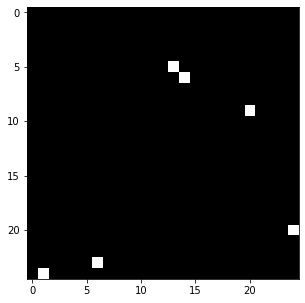

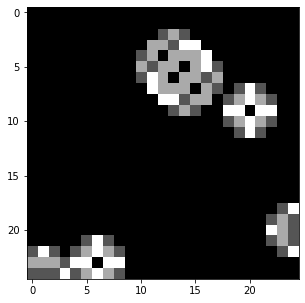

In [12]:
amount = 25; percent = .01; burst_size = 40
spile = AbelianSandpile(amount,ic = [percent, burst_size], snn = True)
print(int(amount*amount*percent*burst_size), 'grains')
raster = spile.run()


/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


AttributeError: 'numpy.ndarray' object has no attribute 'append'

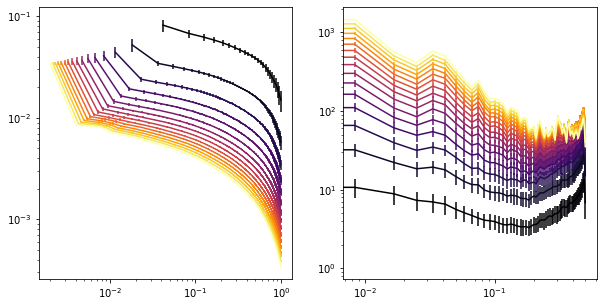

In [51]:
subset_sizes = np.linspace(30,625,16, dtype=int)

decomp_arr = []
eigs, pows, pca_m, s_r2, ft_m, t_r2, psn_r, spn_r, psn_p, spn_p = ramsey.ramsey(pd.DataFrame(raster), subset_sizes, n_pc = 0.8, f_range = [0,0.4])
decomp_arr.append([pca_m, ft_m, psn_r, spn_r, psn_p, spn_p])

decomp_arr = np.array(decomp_arr)

n_iters = 1; n_pc = 0.8; f_range = [0,0.4]; pc_range = [0,None]
ramsey.plot_all_measures(subset_sizes, s_r2, t_r2, n_iters, n_pc, f_range, pc_range, eigs, pows,decomp_arr[:,0].mean(0), decomp_arr[:,1].mean(0), decomp_arr[:,2], decomp_arr[:,3], decomp_arr[:,4], decomp_arr[:,5])

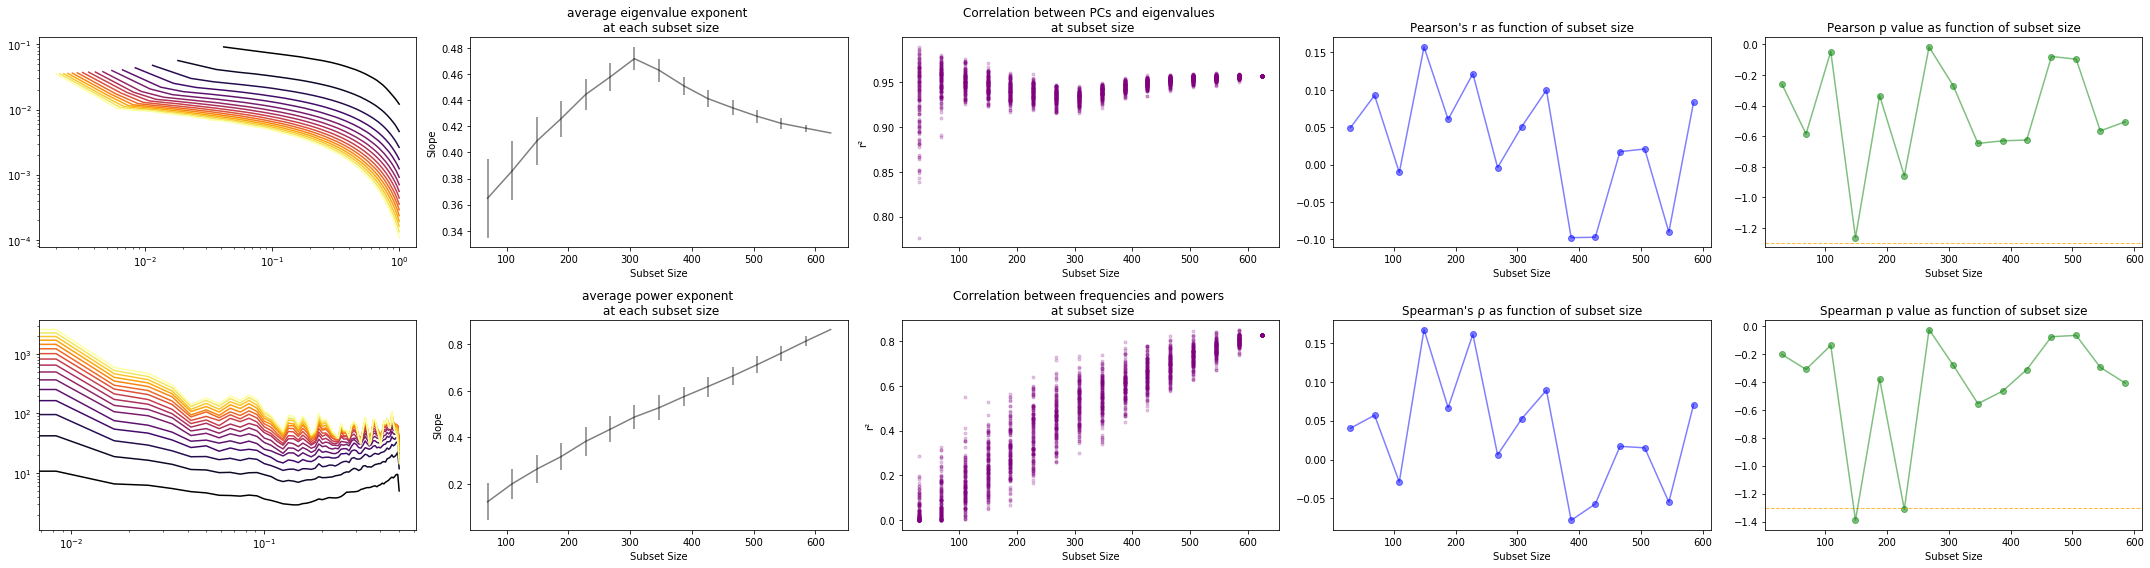

In [48]:
n_iters = 1; n_pc = 0.8; f_range = [0,0.4]; pc_range = [0,None]
ramsey.plot_all_measures(subset_sizes, s_r2, t_r2, n_iters, n_pc, f_range, pc_range, eigs, pows,decomp_arr[:,0].mean(0), decomp_arr[:,1].mean(0), decomp_arr[:,2], decomp_arr[:,3], decomp_arr[:,4], decomp_arr[:,5])

/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/brianbarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


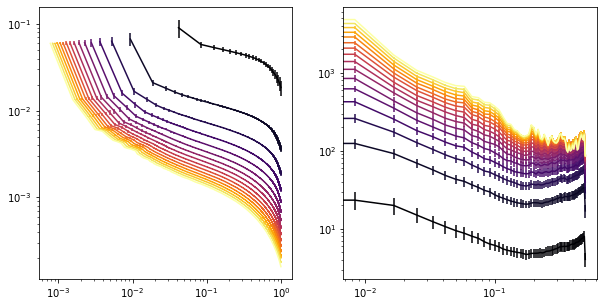

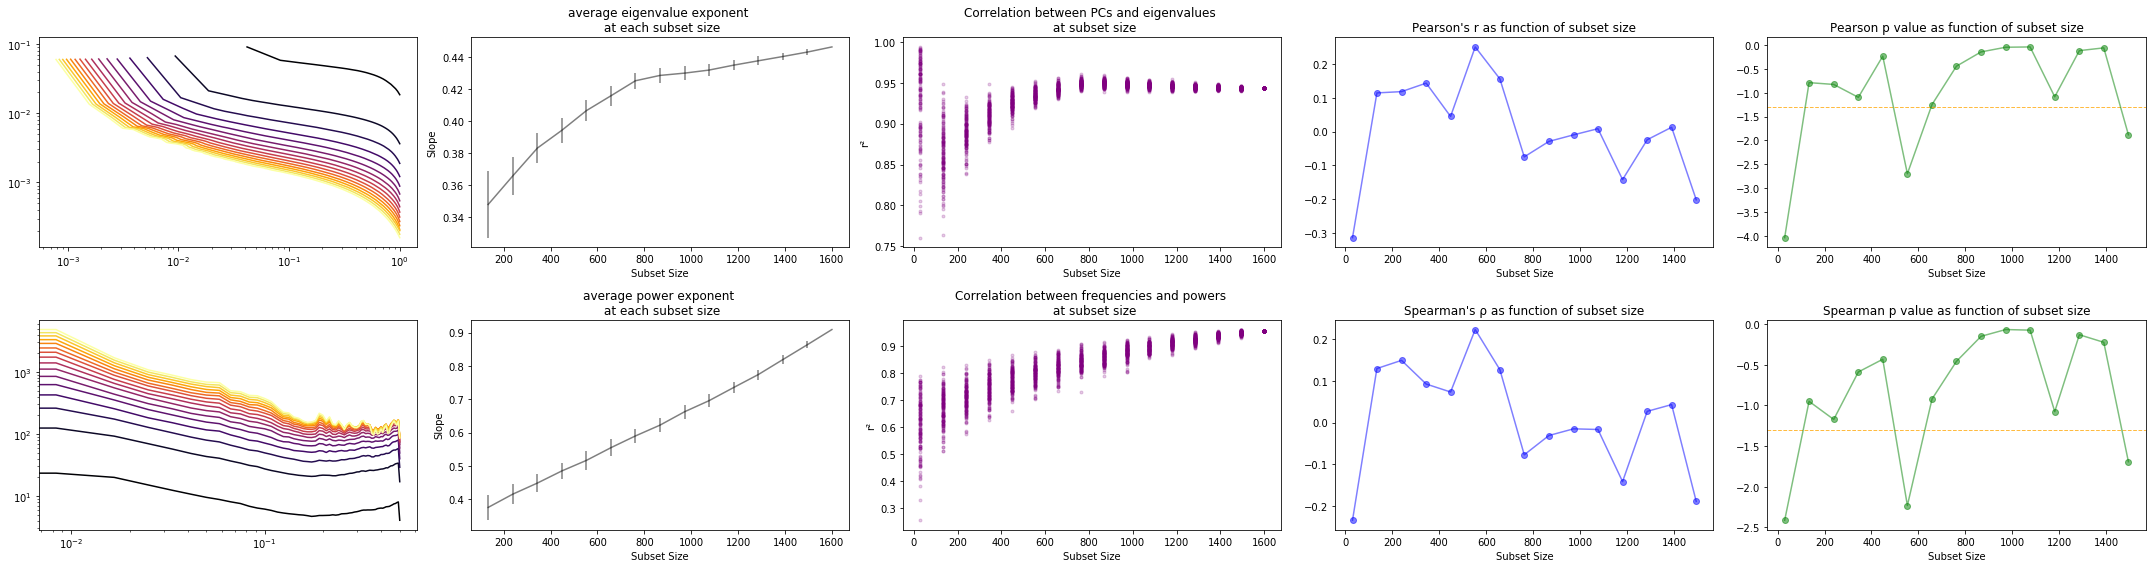

In [9]:
raster = np.load('../data/experiments/sim/SOC_spikes.npy')
subset_sizes = np.linspace(30,1600,16, dtype=int)

decomp_arr = []
eigs, pows, pca_m, s_r2, ft_m, t_r2, psn_r, spn_r, psn_p, spn_p = ramsey.ramsey(pd.DataFrame(raster), subset_sizes, n_pc = 0.8, f_range = [0,0.4])
decomp_arr.append([pca_m, ft_m, psn_r, spn_r, psn_p, spn_p])

decomp_arr = np.array(decomp_arr)

n_iters = 1; n_pc = 0.8; f_range = [0,0.4]; pc_range = [0,None]
ramsey.plot_all_measures(subset_sizes, s_r2, t_r2, n_iters, n_pc, f_range, pc_range, eigs, pows,decomp_arr[:,0].mean(0), decomp_arr[:,1].mean(0), decomp_arr[:,2], decomp_arr[:,3], decomp_arr[:,4], decomp_arr[:,5])

### Now on graphs

- Neuronal avalanches

In [ ]:
def createGraphGrid(size):
    """Creates the lattice graph"""
    
    adj_mat = np.zeros((size**2, size**2), int)
    

In [5]:
lattice = np.array([[0,1,0,1,0,0,0,0,0],
                    [1,0,1,0,1,0,0,0,0],
                    [0,1,0,0,0,1,0,0,0],
                    [1,0,0,0,1,0,1,0,0],
                    [0,1,0,1,0,1,0,1,0],
                    [0,0,1,0,1,0,0,0,1],
                    [0,0,0,1,0,0,0,1,0],
                    [0,0,0,0,1,0,1,0,1],
                    [0,0,0,0,0,1,0,1,0]
])

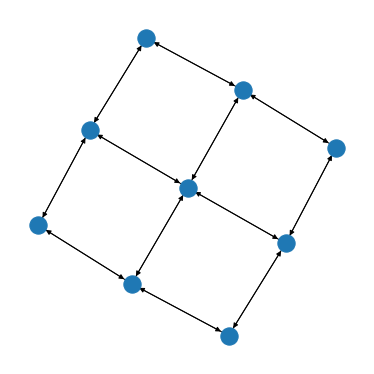

In [10]:
G = nx.DiGraph(lattice)
plt.figure(figsize=[5,5])
nx.draw(G, pos=nx.spring_layout(G))

In [16]:
A = np.array([0,1,0,
              1,4,1,
              0,1,0])
np.linalg.matrix_power(lattice.T, 1)@A.T

def run(mat, ic):
    for i in range(1,10):
        adder = [1 for i in ic if i != 0]
        next_step = np.linalg.matrix_power(mat.T, i)@adder.T
        
        

In [17]:
np.linalg.matrix_power(lattice.T, 1)@A.T

array([2, 4, 2, 4, 4, 4, 2, 4, 2])